# Calculations of sensible heat

Like latent heat flux, sensible heat is typically not measured directly but instead computed from bulk formulae.  The current standard method is using the COARE Bulk Flux Algorithm (see Fairall, C.W., E. F. Bradley, J. E. Hare, A. A. Grachev, and J. B. Edson, 2003: Bulk Parameterization of Air-Sea Fluxes: Updates and Verification for the COARE Algorithm. J. Climate, 16, pp 571-591).

The code for the CBA is avaible in different places, mostly in Matlab and FORTRAN (https://www.pmel.noaa.gov/ocs/flux-documentation).  Here we use a python package for CBA-3.6 (see for example coare_bulk_flux.ipynb).

Sensible heat is based on air density ($\rho_{air}$), specific heat ($C_{P}$, taken as a constant 1004.67 $J/^{\circ}K/kg$), wind speed ($u_{air}$ and temperature ($T_{air}$): 

\begin{eqnarray}
  Q_{h} = \rho_{air} C_{P} u_{*} T_{*}
\end{eqnarray}

## Air density

The density of air is given by

\begin{equation}
  \rho_{air} = \frac{100 \: P_{atm}} {R_{gas} \: [T_{air}+273.16][1+0.61 \: q_{10}]}
\end{equation}

where $P_{atm}$ is atmospheric pressure (mb), $T_{air}$ is air temperature ($^{\circ}C$), $R_{gas}$ is a constant (287.1), and $q_{10}$ is the specific humidity at 10 $m$ (g/kg).  The first two are typically measured, while the last can be computed from the (measured) relative humidity, $R_{h}$, temperature and pressure.  First, the saturation vapor pressure is computed as:

\begin{equation}
  e_{s} = 6.1121 \: e^{\left( \frac{17.502 \: T_{air}}{240.97 + T_{air}} \right) } \left(1.0007 + 3.46 x 10^{-6} \: P_{atm} \right)
\end{equation}

and then

\begin{equation}
  q_{10} = \frac{ 6.22 \: R_{h} \: e_{s} } { P_{atm} - 3.78 x 10^{-3} \: R_{h} \: e_{s} }
\end{equation}

##  Velocity and temperature on "standard" levels 

Wind and temperature sensors can be at different heights above the sea surface.  The ORS buoys typically measure wind at around 4 $m$ while air temperature and humidity are measured at about 2 $m$. Derivation of wind speed $u_{air}$ and air temperature $T_{air}$ at standard heights (typically 10 $m$ and 2 $m$, respectively) are based on vertical shear structure of the boundary layer, determined by the logarithmic profiles, according to the Monin-Obukhov similarity theory (MOST):

\begin{equation}
u_{air}(z) = u_{ocean} + \frac{u_{*}}{\kappa}\left[ ln \left( \frac{z}{z_{o}} \right) - \psi_{u} \left( \frac{z}{L} \right) \right]
\end{equation}

\begin{equation}
  T_{air}(z) = T_{SST} + \frac{T_{*}}{\kappa}\left[ ln \left( \frac{z}{z_{oT}} \right) - \psi_{T} \left( \frac{z}{L} \right) \right]
\end{equation}

where $u_{ocean}$ is the surface ocean current spped; $T_{SST}$ is the ocean surface temperature with warm layer and cool skin temperature correction; $\kappa$ is the von Karman constant; $z_{o}$, $z_{oT}$, and are the roughness lengths for wind and temperature respectively, and $\psi_{u}$ and $psi_{T}$ are the empirical functions describing the stability dependence of the shear profiles for wind speed and temperature and humidity; $L$ is the Monin-Obukhov length; and finally $u_{*}$ and $T_{*}$ are MOST scaling factors.  These equations are solved iteravely to get $u_{*}$ and $T_{*}$.

The matlab version allows for the user to select the level, but the python version fixes this at 10$m$.  The shear profiles are supplied with two different routines.

# COARE parameterizations

We can now look at how the COARE bulk flux algorithm computes these quantities.  It requires as input the following:

| Variable                                             | C4 Name |
|:-----------------------------------------------------|:-------:|
| relative wind speed (m/s) at height zu(m)            | u       | 
| bulk air temperature (degC) at height zt(m)          | t       |
| relative humidity (#) at height zq(m) [0-100]        | rh      |
| surface air pressure (mb) (default = 1015)           | P       |
| water temperature (degC) see jcool below             | ts      |
| downward shortwave radiation (W/m^2) (default = 150) | Rs      | 
| downward longwave radiation (W/m^2) (default = 370)  | Rl      | 
| latitude (default = +45 N)                           | lat     | 
| PBL height (m) (default = 600m)                      | zi      | 
| wind speed measurement height (m)                    | zu      | 
| air T measurement height (m)                         | zt      | 
| air q measurement height (m)                         | zq      |

In [1]:
# turn off warnings
import warnings; warnings.simplefilter('ignore')

# external packages
import numpy as np
import sys
from netCDF4 import Dataset
import pandas as pd
import matplotlib.pyplot as plt

# internal packages
sys.path.insert(1, './coare')
from coare4 import coare4

## 1. Example with scalar values

In [2]:
wind_speed = np.array([20.0])
wind_sensor_hgt = np.array([2.0])
Tair = np.array([18.0])
air_sensor_hgt = np.array([2.0])
rel_humid = np.array([80.0])
humid_sensor_hgt = np.array([2.0])
pressure = np.array([1011.0])
Tocean = np.array([19.0])

lat = np.array([20.0])
pbl_height = np.array([600.0])

# not used for evap, but needed for CBA
shortwave = np.array([400.0])
longwave = np.array([100.0])

In [3]:
# add all the input into a dictionary and call CBA
inputs = {'u':wind_speed,'zu':wind_sensor_hgt,'t':Tair,'zt':air_sensor_hgt,
          'rh':rel_humid,'zq':humid_sensor_hgt,'P':pressure,'ts':Tocean,
          'Rs':shortwave,'Rl':longwave,'lat':lat,'zi':pbl_height}
res = coare4(inputs)

In [5]:
print('Air density: ', res['rhoa'])
print('$u_{*}$: ', res['usr'])
print('$T_{*}$:', res['tsr'])
print('Sensible heat flux: ', res['hsb'])

Air density:  [1.20192285]
$u_{*}$:  [1.389441702772625]
$T_{*}$: [-0.020200540097535375]
Sensible heat flux:  [33.89247916413143]


## 2.  Sensible heat dependency on different parameters

In [6]:
# Here we experiment by fixing all variables except one, and see the impact

# wind speed varies from 0 to 20 m/s (roughly 0 to 45 kts)
wind_speed = np.arange(0.0, 20.0, 0.1)

# note here we have to have all the rest as arrays, but with a single, constant value
nt = len(wind_speed)
wind_sensor_hgt = np.full( nt, 2.0 )
Tair = np.full( nt, 18.0 )
air_sensor_hgt = np.full( nt, 2.0 )
rel_humid = np.full( nt, 80.0 )
humid_sensor_hgt = np.full( nt, 2.0 )
pressure = np.full( nt, 1011.0 )
Tocean = np.full( nt, 19.0 )

lat = np.full( nt, 20.0 )
pbl_height = np.full( nt, 600.0 )

# not used for evap, but needed for CBA
shortwave = np.full( nt, 400.0 )
longwave = np.full( nt, 100.0 )

In [7]:
# add all the input into a dictionary and call CBA
inputs = {'u':wind_speed,'zu':wind_sensor_hgt,'t':Tair,'zt':air_sensor_hgt,
          'rh':rel_humid,'zq':humid_sensor_hgt,'P':pressure,'ts':Tocean,
          'Rs':shortwave,'Rl':longwave,'lat':lat,'zi':pbl_height}
res = coare4(inputs)

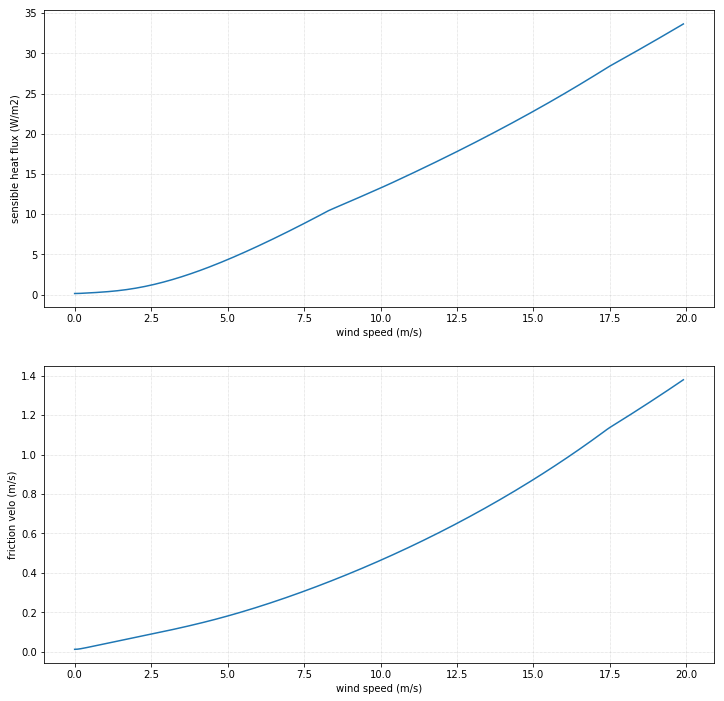

In [9]:
# make a plot
fig, ax = plt.subplots( figsize = ( 12, 12 ), nrows = 2 )

ax[0].plot(wind_speed,res['hsb'])
ax[0].set_xlabel('wind speed (m/s)')
ax[0].set_ylabel('sensible heat flux (W/m2)')
ax[0].grid(linestyle=':', linewidth=0.5)

ax[1].plot(wind_speed,res['usr'])
ax[1].set_xlabel('wind speed (m/s)')
ax[1].set_ylabel('friction velo (m/s)')
ax[1].grid(linestyle=':', linewidth=0.5)

In [10]:
# relative humidity varies from 10% to 90%
rel_humid = np.arange(10.0, 90.0, 1.0 )

# note here we have to have all the rest as arrays, but with a single, constant value
nt = len(rel_humid)
wind_speed = np.full( nt, 8.0 )
wind_sensor_hgt = np.full( nt, 2.0 )
Tair = np.full( nt, 18.0 )
air_sensor_hgt = np.full( nt, 2.0 )
humid_sensor_hgt = np.full( nt, 2.0 )
pressure = np.full( nt, 1011.0 )
Tocean = np.full( nt, 19.0 )

lat = np.full( nt, 20.0 )
pbl_height = np.full( nt, 600.0 )

# not used for evap, but needed for CBA
shortwave = np.full( nt, 400.0 )
longwave = np.full( nt, 100.0 )

In [11]:
# add all the input into a dictionary and call CBA
inputs = {'u':wind_speed,'zu':wind_sensor_hgt,'t':Tair,'zt':air_sensor_hgt,
          'rh':rel_humid,'zq':humid_sensor_hgt,'P':pressure,'ts':Tocean,
          'Rs':shortwave,'Rl':longwave,'lat':lat,'zi':pbl_height}
res = coare4(inputs)

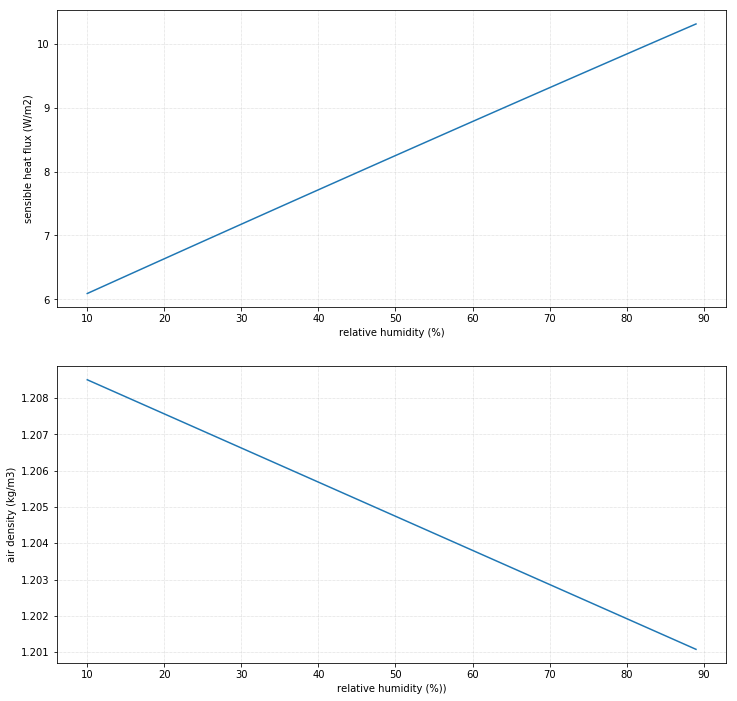

In [12]:
# make a plot
fig, ax = plt.subplots( figsize = ( 12, 12 ), nrows = 2 )

ax[0].plot(rel_humid,res['hsb'])
ax[0].set_xlabel('relative humidity (%)')
ax[0].set_ylabel('sensible heat flux (W/m2)')
ax[0].grid(linestyle=':', linewidth=0.5)

ax[1].plot(rel_humid,res['rhoa'])
ax[1].set_xlabel('relative humidity (%)')
ax[1].set_ylabel('air density (kg/m3)')
ax[1].grid(linestyle=':', linewidth=0.5)

In [13]:
# pressure ranges from 1000 to 1020
pressure = np.arange(1000.0,1020.0,0.5)

# note here we have to have all the rest as arrays, but with a single, constant value
nt = len(pressure)
wind_speed = np.full( nt, 8.0 )
wind_sensor_hgt = np.full( nt, 2.0 )
rel_humid = np.full( nt, 80.0 )
humid_sensor_hgt = np.full( nt, 2.0 )
Tair = np.full( nt, 18.0 )
air_sensor_hgt = np.full( nt, 2.0 )
Tocean = np.full( nt, 19.0 )

lat = np.full( nt, 20.0 )
pbl_height = np.full( nt, 600.0 )

# not used for evap, but needed for CBA
shortwave = np.full( nt, 400.0 )
longwave = np.full( nt, 100.0 )

In [14]:
# add all the input into a dictionary and call CBA
inputs = {'u':wind_speed,'zu':wind_sensor_hgt,'t':Tair,'zt':air_sensor_hgt,
          'rh':rel_humid,'zq':humid_sensor_hgt,'P':pressure,'ts':Tocean,
          'Rs':shortwave,'Rl':longwave,'lat':lat,'zi':pbl_height}
res = coare4(inputs)

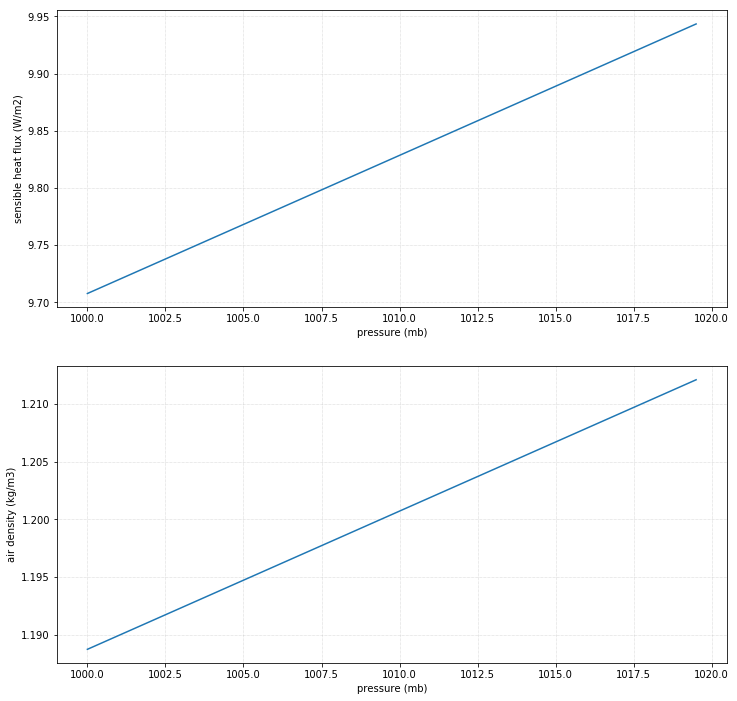

In [15]:
# make a plot
fig, ax = plt.subplots( figsize = ( 12, 12 ), nrows = 2 )

ax[0].plot(pressure,res['hsb'])
ax[0].set_xlabel('pressure (mb)')
ax[0].set_ylabel('sensible heat flux (W/m2)')
ax[0].grid(linestyle=':', linewidth=0.5)

ax[1].plot(pressure,res['rhoa'])
ax[1].set_xlabel('pressure (mb)')
ax[1].set_ylabel('air density (kg/m3)')
ax[1].grid(linestyle=':', linewidth=0.5)

In [21]:
# Air temperature ranges from 15 to 30
Tair = np.arange(15.0,30.0,0.2)
Tocean1 = Tair + 0.5
Tocean2 = Tair + 1.0
Tocean3 = Tair + 2.0

# note here we have to have all the rest as arrays, but with a single, constant value
nt = len(Tair)
wind_speed = np.full( nt, 8.0 )
wind_sensor_hgt = np.full( nt, 2.0 )
rel_humid = np.full( nt, 80.0 )
humid_sensor_hgt = np.full( nt, 2.0 )
air_sensor_hgt = np.full( nt, 2.0 )
pressure = np.full( nt, 1011.0 )

lat = np.full( nt, 20.0 )
pbl_height = np.full( nt, 600.0 )

# not used for evap, but needed for CBA
shortwave = np.full( nt, 400.0 )
longwave = np.full( nt, 100.0 )

In [22]:
# add all the input into a dictionary and call CBA
inputs = {'u':wind_speed,'zu':wind_sensor_hgt,'t':Tair,'zt':air_sensor_hgt,
          'rh':rel_humid,'zq':humid_sensor_hgt,'P':pressure,'ts':Tocean1,
          'Rs':shortwave,'Rl':longwave,'lat':lat,'zi':pbl_height}
res1 = coare4(inputs)
inputs = {'u':wind_speed,'zu':wind_sensor_hgt,'t':Tair,'zt':air_sensor_hgt,
          'rh':rel_humid,'zq':humid_sensor_hgt,'P':pressure,'ts':Tocean2,
          'Rs':shortwave,'Rl':longwave,'lat':lat,'zi':pbl_height}
res2 = coare4(inputs)
inputs = {'u':wind_speed,'zu':wind_sensor_hgt,'t':Tair,'zt':air_sensor_hgt,
          'rh':rel_humid,'zq':humid_sensor_hgt,'P':pressure,'ts':Tocean3,
          'Rs':shortwave,'Rl':longwave,'lat':lat,'zi':pbl_height}
res3 = coare4(inputs)

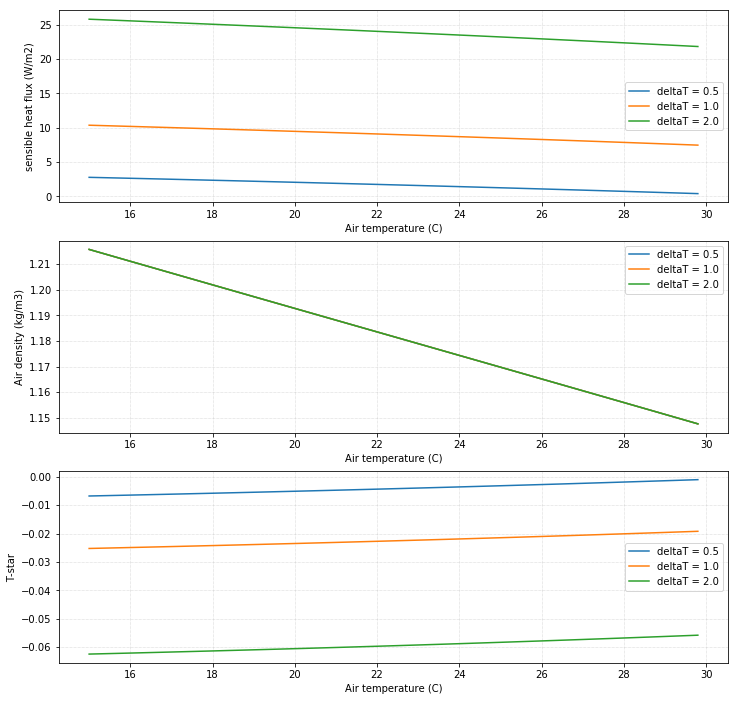

In [23]:
# make a plot
fig, ax = plt.subplots( figsize = ( 12, 12 ), nrows = 3 )

ax[0].plot(Tair,res1['hsb'],label='deltaT = 0.5')
ax[0].plot(Tair,res2['hsb'],label='deltaT = 1.0')
ax[0].plot(Tair,res3['hsb'],label='deltaT = 2.0')
ax[0].set_xlabel('Air temperature (C)')
ax[0].set_ylabel('sensible heat flux (W/m2)')
ax[0].grid(linestyle=':', linewidth=0.5)
ax[0].legend()

ax[1].plot(Tair,res1['rhoa'],label='deltaT = 0.5')
ax[1].plot(Tair,res2['rhoa'],label='deltaT = 1.0')
ax[1].plot(Tair,res3['rhoa'],label='deltaT = 2.0')
ax[1].set_xlabel('Air temperature (C)')
ax[1].set_ylabel('Air density (kg/m3)')
ax[1].grid(linestyle=':', linewidth=0.5)
ax[1].legend()

ax[2].plot(Tair,res1['tsr'],label='deltaT = 0.5')
ax[2].plot(Tair,res2['tsr'],label='deltaT = 1.0')
ax[2].plot(Tair,res3['tsr'],label='deltaT = 2.0')
ax[2].set_xlabel('Air temperature (C)')
ax[2].set_ylabel('T-star')
ax[2].grid(linestyle=':', linewidth=0.5)
ax[2].legend()

In [2]:
# Read model output and observations from ORS

In [3]:
site = 'WHOTS'
lat = 22.7667
lon = -157.8983